In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


# from sklearn.decomposition import PCA
from scipy import stats
# from sklearn.cluster import KMeans
# from sklearn import metrics
# from scipy.spatial.distance import cdist
# from sklearn.metrics import davies_bouldin_score

import pickle
import copy
# from shapely import geometry
# from sklearn.metrics.pairwise import euclidean_distances
# import statsmodels.api as sm
from scipy.stats import linregress
# from sklearn.metrics import accuracy_score
import math
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# from scipy.stats import ks_2samp

In [2]:
import string
abcd = list(string.ascii_lowercase)

In [3]:
names_reanalyses = ['ERA5',
                   'JRA3Q',
                   'NCEP_NCAR']

In [4]:
dic_labels = {}
for reanalysis in names_reanalyses:
    labels_temp = pd.read_csv(f'../ProcessZ500/labels/df_labels_nocorrfilt_{reanalysis}.csv', parse_dates=True, index_col=0, 
                              names=['WR','distances','corr'], skiprows=1)#[['WR']]
    labels_temp = labels_temp['1948':]
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    labels_temp.loc[labels_temp['corr']<=0.2,'WR']=np.unique(labels_temp['WR'])[-1]
    dic_labels[reanalysis] = labels_temp

In [5]:
dic_events = {}

for ir, reanalysis in enumerate(names_reanalyses):
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels[reanalysis])
    
    df_labels['season'] = df_labels.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_labels['season'] = df_labels['season'].map(season_map)
    
    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    # df_events = df_events[df_events['duration']>=4]
    dic_events[reanalysis] = df_events

/glade/derecho/scratch/jhayron/tmp/ipykernel_57603/2337241071.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_57603/2337241071.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_57603/2337241071.py:16: FutureWarning: A value

In [6]:
N=30

dic_stats_durations = {}
dic_dfs_durations = {}

for ir, reanalysis in enumerate(names_reanalyses):
    dic_stats_durations[reanalysis] = {}
    dic_dfs_durations[reanalysis] = {}
    start_year = dic_labels[reanalysis].index.year[0] + (N-1)
    end_year = dic_labels[reanalysis].index.year[-1]
    for wr in range(6):
        df_temp = copy.deepcopy(dic_events[reanalysis])
        df_temp = df_temp[(df_temp['season']=='Winter')|(df_temp['season']=='Spring')]
        df_temp = df_temp[df_temp['WR']==wr]
        
        dic_stats_temp = {}
        dic_stats_temp['mean'] = []
        dic_stats_temp['std'] = []
        dic_stats_temp['p90'] = []
        dic_stats_temp['p10'] = []
        dic_stats_temp['p95'] = []
        dic_stats_temp['p05'] = []
        dic_stats_temp['n_events'] = []
        dic_stats_temp['n_days'] = []
        
        for year in range(start_year, end_year+1):
            df_temp_temp = df_temp.loc[str(year-N+1):str(year)]['duration']
            dic_stats_temp['mean'].append(df_temp_temp.mean())
            dic_stats_temp['std'].append(df_temp_temp.std())
            dic_stats_temp['p90'].append(df_temp_temp.quantile(0.9))
            dic_stats_temp['p10'].append(df_temp_temp.quantile(0.1))
            dic_stats_temp['p95'].append(df_temp_temp.quantile(0.95))
            dic_stats_temp['p05'].append(df_temp_temp.quantile(0.05))

            dic_stats_temp['n_events'].append(len(df_temp_temp)/30)
            dic_stats_temp['n_days'].append(df_temp_temp.sum()/(30*365/2))
        df_stats_temp = pd.DataFrame(dic_stats_temp,index=np.arange(start_year,end_year+1))
        dic_stats_durations[reanalysis][f'wr{wr}'] = df_stats_temp
        dic_dfs_durations[reanalysis][f'wr{wr}'] = df_temp

In [7]:
wr=1

In [8]:
names_wrs = ["Polar High", "Pacific Trough", "Pacific Ridge", "Alaskan Ridge", "Atlantic Ridge" ,"No WR"]

In [9]:
colors_reanalyses = {'ERA5':'k','JRA3Q':'red','NCEP_NCAR':'blue'}

In [10]:
from scipy.stats import theilslopes
import statsmodels.api as sm

# Z500 difference

In [11]:
z500_diff = xr.open_dataset('../ProcessERA5_Surface/diffs_data/z500_diff.nc')

arr = z500_diff.difference.values

longmean = np.nanmean(arr, axis=1, keepdims=True)
longstd = np.nanstd(arr, axis=1, keepdims=True)

arr[(arr<=z500_diff.q95.values)&(arr>=z500_diff.q05.values)] = np.nan
# arr = (arr-longmean)/longstd
z500_diff.difference.data = arr

# Precip difference

In [12]:
precip_diff = xr.open_dataset('../ProcessERA5_Surface/diffs_data/precip_diff.nc')
# precip_diff = (precip_diff - precip_diff.mean(dim='lon'))/(precip_diff.std(dim='lon'))
arr = precip_diff.difference.values
arr[(arr<=precip_diff.q95.values)&(arr>=precip_diff.q05.values)] = np.nan
precip_diff.difference.data = arr

# temp difference

In [13]:
maxtemp_diff = xr.open_dataset('../ProcessERA5_Surface/diffs_data/max_temp_diff.nc')
# maxtemp_diff = (maxtemp_diff - maxtemp_diff.mean(dim='lon'))/(maxtemp_diff.std(dim='lon'))
arr = maxtemp_diff.difference.values
arr[(arr<=maxtemp_diff.q95.values)&(arr>=maxtemp_diff.q05.values)] = np.nan
maxtemp_diff.difference.data = arr

# Extremely hot days

In [14]:
tx90_diff = xr.open_dataset('../ProcessERA5_Surface/diffs_data/tx90_diff.nc')
arr = tx90_diff.difference_percent.values
arr[(tx90_diff.difference.values<=tx90_diff.q95.values)&(tx90_diff.difference.values>=tx90_diff.q05.values)] = np.nan
tx90_diff.difference_percent.data = arr

In [15]:
tx90_pt_diff = xr.open_dataset('../ProcessERA5_Surface/diffs_data/tx90_pt_diff.nc')
tx90_pt_diff_bt2 = xr.open_dataset('../ProcessERA5_Surface/diffs_data/tx90_pt_diff_bt2.nc')
arr = tx90_pt_diff.difference.values
arr[(arr<=tx90_pt_diff.q95.values)&(arr>=tx90_pt_diff.q05.values)] = np.nan
arr[(arr<=tx90_pt_diff_bt2.q95.values)&(arr>=tx90_pt_diff_bt2.q05.values)] = np.nan

tx90_pt_diff.difference.data = arr

In [16]:
tx90_corr = xr.open_dataset('../ProcessERA5_Surface/corr_data/corr_tx90_anoms.nc')

# Extremely hot spells

In [17]:
ws_diff = xr.open_dataset('../ProcessERA5_Surface/diffs_data/ws_diff.nc')
arr = ws_diff.difference_percent.values
arr[(ws_diff.difference.values<=ws_diff.q95.values)&(ws_diff.difference.values>=ws_diff.q05.values)] = np.nan
ws_diff.difference_percent.data = arr

In [18]:
ws_pt_diff = xr.open_dataset('../ProcessERA5_Surface/diffs_data/ws_pt_diff.nc')
ws_pt_diff_bt2 = xr.open_dataset('../ProcessERA5_Surface/diffs_data/ws_pt_diff_bt2.nc')
arr = ws_pt_diff.difference.values
arr[(arr<=ws_pt_diff.q95.values)&(arr>=ws_pt_diff.q05.values)] = np.nan
arr[(arr<=ws_pt_diff_bt2.q95.values)&(arr>=ws_pt_diff_bt2.q05.values)] = np.nan
ws_pt_diff.difference.data = arr

In [19]:
ws_corr = xr.open_dataset('../ProcessERA5_Surface/corr_data/corr_ws.nc')

/glade/derecho/scratch/jhayron/tmp/ipykernel_57603/3707426427.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 4, 1, projection=ccrs.AlbersEqualArea(
/glade/derecho/scratch/jhayron/tmp/ipykernel_57603/3707426427.py:59: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 4, 3, projection=ccrs.AlbersEqualArea(
/glade/derecho/scratch/jhayron/tmp/ipykernel_57603/3707426427.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 4, 2, projection=ccrs.AlbersEqualArea(
/glade/derecho/scratch/jhayron/tmp/ipykernel_57603/3707426427.py:135: MatplotlibDeprecationWar

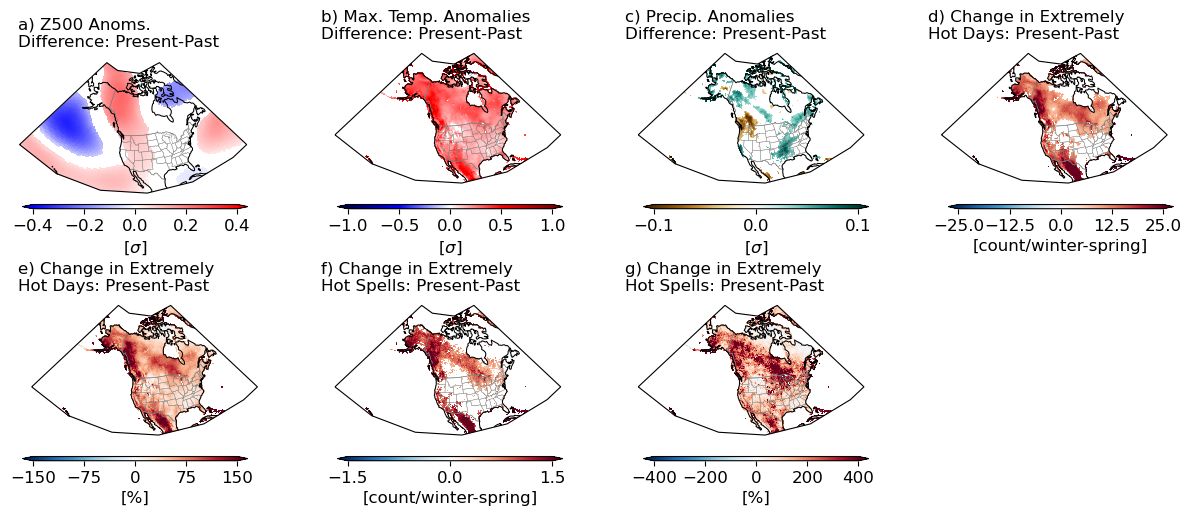

In [25]:
fontsize_most_things = 12
fontsize = fontsize_most_things

fig, axs = plt.subplots(
        2, 4,
        figsize=(15, 6))

axs_list = axs.flatten().tolist()
extent = [-180, -50, 20, 80]
# Create a rectangular boundary matching the extent
verts = [
    (extent[0], extent[2]),  # Bottom-left corner
    (extent[1], extent[2]),  # Bottom-right corner
    (extent[1], extent[3]),  # Top-right corner
    (extent[0], extent[3]),  # Top-left corner
    (extent[0], extent[2])   # Closing the rectangle
]

# ################# PLOT Z500 diff ######################

ax = plt.subplot(2, 4, 1, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-0.4
maxi=0.4
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(z500_diff.lon, 
        z500_diff.lat, 
        z500_diff.difference,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='bwr')

ax.set_title(
    f'a) Z500 Anoms.\nDifference: Present-Past', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.128, 0.565, 0.15, 0.007])
ticks_1 = [-0.4, -0.2, 0, 0.2, 0.4]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

# ################# PLOT Precip diff ######################

ax = plt.subplot(2, 4, 3, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-0.1
maxi=0.1
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(precip_diff.lon, 
        precip_diff.lat, 
        precip_diff.difference,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='BrBG')

ax.set_title(
    f'c) Precip. Anomalies\nDifference: Present-Past', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.542, 0.565, 0.15, 0.007])
ticks_1 = [-0.1, 0, 0.1]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

# ################# PLOT Tmax diff ######################

ax = plt.subplot(2, 4, 2, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-1
maxi=1
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(maxtemp_diff.lon, 
        maxtemp_diff.lat, 
        maxtemp_diff.difference,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='seismic')

ax.set_title(
    f'b) Max. Temp. Anomalies\nDifference: Present-Past', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())


cbar_ax = fig.add_axes([0.338, 0.565, 0.15, 0.007])
ticks_1 = [-1, -0.5, 0, 0.5, 1]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1, orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

# ################# PLOT extremely hot days diff count ######################

ax = plt.subplot(2, 4, 4, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-25
maxi=25
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tx90_diff.lon, 
        tx90_diff.lat, 
        tx90_diff.difference,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'd) Change in Extremely\nHot Days: Present-Past', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.745, 0.565, 0.15, 0.007])
ticks_1 = [-25, -12.5, 0, 12.5, 25]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1, orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[count/winter-spring]', fontsize=fontsize_most_things)

# ################# PLOT extremely hot days diff ######################

ax = plt.subplot(2, 4, 5, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-150
maxi=150
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tx90_diff.lon, 
        tx90_diff.lat, 
        tx90_diff.difference_percent*100,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'e) Change in Extremely\nHot Days: Present-Past', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.128, 0.145, 0.15, 0.007])
ticks_1 = [-150, -75, 0, 75, 150]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1, orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[%]', fontsize=fontsize_most_things)



# ################# PLOT warm spells PT diff count ######################

ax = plt.subplot(2, 4, 6, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-1.5
maxi=1.5
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(ws_diff.lon, 
        ws_diff.lat, 
        ws_diff.difference,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'f) Change in Extremely\nHot Spells: Present-Past', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.338, 0.145, 0.15, 0.007])
ticks_1 = [-1.5, 0, 1.5]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1, orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[count/winter-spring]', fontsize=fontsize_most_things)


# ################# PLOT warm spells PT diff % ######################

ax = plt.subplot(2, 4, 7, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-400
maxi=400
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(ws_diff.lon, 
        ws_diff.lat, 
        ws_diff.difference_percent*100,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'g) Change in Extremely\nHot Spells: Present-Past', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.542, 0.145, 0.15, 0.007])
ticks_1 = [-400, -200, 0, 200, 400]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1, orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[%]', fontsize=fontsize_most_things)

fig.delaxes(axs[1, 3])  # This deletes the bottom-right subplot (2nd row, 4th column)

# plt.tight_layout()
plt.savefig('nFigures/4_seasonal_changes.png',bbox_inches='tight')